Download data

In [1]:
#!wget https://download.pytorch.org/tutorial/data.zip
#!unzip data.zip
#!ls

In [2]:
%matplotlib inline


Generating Names with a Character-Level RNN
*******************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In the :doc:`last tutorial </intermediate/char_rnn_classification_tutorial>`
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import math
import random

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


Creating the Network
====================

This network extends `the last tutorial's RNN <#Creating-the-Network>`__
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [5]:
#Part 2, ii
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN_ii(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_ii, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
#Part 2 - iii
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN_iii(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_iii, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories  + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories+  hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        input_combined_no_input = torch.cat((category, hidden), 1)
        hidden = self.i2h(input_combined_no_input)
        output = self.i2o(input_combined_no_input)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [7]:
#part 2 - iv

import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN_iv(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_iv, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories  + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories+  hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        input_combined_no_input = torch.cat((category, hidden), 1)
        hidden = self.i2h(input_combined_no_input)
        output = self.i2o(input_combined_no_input)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [8]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [9]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [10]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [11]:
criterion = nn.NLLLoss()

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [12]:
#part 2-ii
criterion = nn.NLLLoss()

def train_ii(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_ii.initHidden()

    rnn_ii.zero_grad()

    loss_ii = 0

    for i in range(input_line_tensor.size(0)):
        if i>0:
            category_tensor = torch.zeros(1, n_categories)
        output, hidden = rnn_ii(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss_ii += l

    # compute the gradient by backpropagation
    loss_ii.backward()

    # update the parameters
    optimizer_ii.step()

    return output, loss_ii.item() / input_line_tensor.size(0)

In [13]:
#part 2 - iii
criterion = nn.NLLLoss()

def train_iii(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_iii.initHidden()

    rnn_iii.zero_grad()

    loss_iii = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn_iii(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss_iii += l

    # compute the gradient by backpropagation
    loss_iii.backward()

    # update the parameters
    optimizer_iii.step()

    return output, loss_iii.item() / input_line_tensor.size(0)

In [14]:
#part 2 - iv

criterion = nn.NLLLoss()

def train_iv(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_iv.initHidden()

    rnn_iv.zero_grad()

    loss_iv = 0

    for i in range(input_line_tensor.size(0)):
        if i>0:
            category_tensor = torch.zeros(1, n_categories)
        output, hidden = rnn_iv(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss_iv += l

    # compute the gradient by backpropagation
    loss_iv.backward()

    # update the parameters
    optimizer_iv.step()

    return output, loss_iv.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [15]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [16]:
rnn = RNN(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses = []
all_validation_losses = []
train_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    train_loss += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

    if iter % plot_every == 0:
        all_train_losses.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss = eval_dataset(validation_data)

        # save model with best validation loss
        if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
            torch.save(rnn, 'char_rnn_generation_model.pt')
        all_validation_losses.append(average_validation_loss)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 6s) 	2.4261
5000 	12% 	(0m 14s) 	2.3637
7500 	18% 	(0m 21s) 	2.2907
10000 	25% 	(0m 29s) 	2.2892
12500 	31% 	(0m 37s) 	2.2348
15000 	37% 	(0m 44s) 	2.2589
17500 	43% 	(0m 52s) 	2.2342
20000 	50% 	(1m 0s) 	2.2814
22500 	56% 	(1m 7s) 	2.2464
25000 	62% 	(1m 15s) 	2.2147
27500 	68% 	(1m 23s) 	2.2042
30000 	75% 	(1m 30s) 	2.1982
32500 	81% 	(1m 38s) 	2.2714
35000 	87% 	(1m 45s) 	2.2019
37500 	93% 	(1m 53s) 	2.2440
40000 	100% 	(2m 1s) 	2.1762


In [17]:
#Part 2-ii
rnn_ii = RNN_ii(n_letters, 128, n_letters)
optimizer_ii = torch.optim.Adam(rnn_ii.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses_ii = []
all_validation_losses_ii = []
train_loss_ii = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate_ii(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_ii.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        if i>0:
            category_tensor = torch.zeros(1, n_categories)
        output, hidden = rnn_ii(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset_ii(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate_ii(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
    #if iter>1:
    #    category_tensor = torch.zeros(1, n_categories)
    output, loss = train_ii(category_tensor, input_line_tensor, target_line_tensor)
        
    train_loss_ii += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_ii / plot_every))

    if iter % plot_every == 0:
        all_train_losses_ii.append(train_loss_ii / plot_every)
        train_loss_ii = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_ii = eval_dataset_ii(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_ii) == 0 or average_validation_loss_ii < min(all_validation_losses_ii):
            torch.save(rnn_ii, 'char_rnn_ii_generation_model.pt')
        all_validation_losses_ii.append(average_validation_loss_ii)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 6s) 	2.4923
5000 	12% 	(0m 14s) 	2.3374
7500 	18% 	(0m 22s) 	2.3214
10000 	25% 	(0m 30s) 	2.3092
12500 	31% 	(0m 38s) 	2.3034
15000 	37% 	(0m 46s) 	2.2634
17500 	43% 	(0m 54s) 	2.2546
20000 	50% 	(1m 1s) 	2.2077
22500 	56% 	(1m 9s) 	2.2378
25000 	62% 	(1m 17s) 	2.2177
27500 	68% 	(1m 25s) 	2.2107
30000 	75% 	(1m 33s) 	2.2105
32500 	81% 	(1m 41s) 	2.1962
35000 	87% 	(1m 49s) 	2.2176
37500 	93% 	(1m 57s) 	2.2052
40000 	100% 	(2m 5s) 	2.1915


In [18]:
#Part 2 - iii
rnn_iii = RNN_iii(n_letters, 128, n_letters)
optimizer_iii = torch.optim.Adam(rnn_iii.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses_iii = []
all_validation_losses_iii = []
train_loss_iii = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate_iii(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_iii.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn_iii(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset_iii(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate_iii(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
    output, loss = train_iii(category_tensor, input_line_tensor, target_line_tensor)
        
    train_loss_iii += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_iii / plot_every))

    if iter % plot_every == 0:
        all_train_losses_iii.append(train_loss_iii / plot_every)
        train_loss_iii = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_iii = eval_dataset_iii(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_iii) == 0 or average_validation_loss_iii < min(all_validation_losses_iii):
            torch.save(rnn_iii, 'char_rnn_iii_generation_model.pt')
        all_validation_losses_iii.append(average_validation_loss_iii)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 6s) 	2.6792
5000 	12% 	(0m 14s) 	2.6667
7500 	18% 	(0m 21s) 	2.6387
10000 	25% 	(0m 29s) 	2.5791
12500 	31% 	(0m 37s) 	2.6534
15000 	37% 	(0m 44s) 	2.6364
17500 	43% 	(0m 52s) 	2.6410
20000 	50% 	(0m 59s) 	2.6261
22500 	56% 	(1m 7s) 	2.6014
25000 	62% 	(1m 15s) 	2.5437
27500 	68% 	(1m 22s) 	2.6195
30000 	75% 	(1m 30s) 	2.6008
32500 	81% 	(1m 37s) 	2.6110
35000 	87% 	(1m 45s) 	2.5998
37500 	93% 	(1m 53s) 	2.5809
40000 	100% 	(2m 0s) 	2.5817


In [19]:
# part 2 -iv

rnn_iv = RNN_iv(n_letters, 128, n_letters)
optimizer_iv = torch.optim.Adam(rnn_iv.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses_iv = []
all_validation_losses_iv = []
train_loss_iv = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate_iv(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_iv.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        if i>0:
            category_tensor = torch.zeros(1, n_categories)
        output, hidden = rnn_iv(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset_iv(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate_iv(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
    #if iter>1:
    #    category_tensor = torch.zeros(1, n_categories)
    
    output, loss = train_iv(category_tensor, input_line_tensor, target_line_tensor)
        
    train_loss_iv += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_iv / plot_every))

    if iter % plot_every == 0:
        all_train_losses_iv.append(train_loss_iv / plot_every)
        train_loss_iv = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_iv = eval_dataset_iv(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_iv) == 0 or average_validation_loss_iv < min(all_validation_losses_iv):
            torch.save(rnn_iv, 'char_rnn_iv_generation_model.pt')
        all_validation_losses_iv.append(average_validation_loss_iv)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 6s) 	2.7169
5000 	12% 	(0m 14s) 	2.7240
7500 	18% 	(0m 22s) 	2.6306
10000 	25% 	(0m 30s) 	2.6563
12500 	31% 	(0m 37s) 	2.6488
15000 	37% 	(0m 45s) 	2.6394
17500 	43% 	(0m 53s) 	2.6215
20000 	50% 	(1m 1s) 	2.6335
22500 	56% 	(1m 9s) 	2.6141
25000 	62% 	(1m 16s) 	2.6377
27500 	68% 	(1m 25s) 	2.6293
30000 	75% 	(1m 33s) 	2.5965
32500 	81% 	(1m 40s) 	2.6303
35000 	87% 	(1m 48s) 	2.6646
37500 	93% 	(1m 56s) 	2.6178
40000 	100% 	(2m 4s) 	2.5901


Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




Average test loss: 2.4475239900482197
Average test loss_ii: 2.47437234501033
Average test loss_iii: 2.8012262171429523
Average test loss_iv: 2.8193166650413177


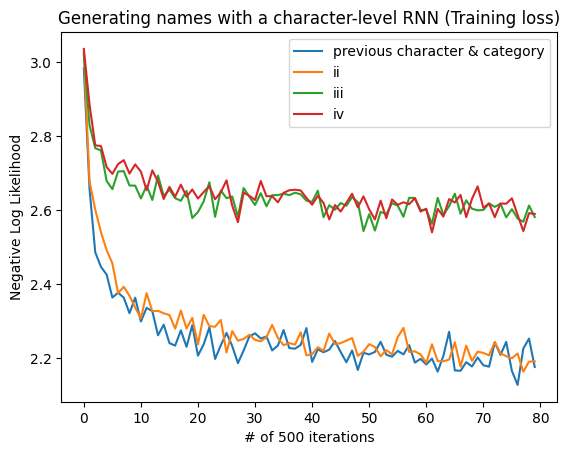

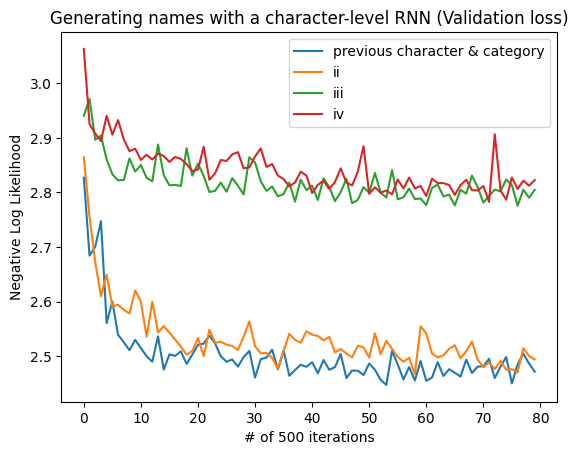

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses,label='Curve 1')
plt.plot(all_train_losses_ii,label='Curve 2')
plt.plot(all_train_losses_iii,label='Curve 3')
plt.plot(all_train_losses_iv,label='Curve 4')
plt.title('Generating names with a character-level RNN (Training loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(['previous character & category','ii','iii','iv'], loc='upper right')

plt.figure()
plt.plot(all_validation_losses,label='Curve 1')
plt.plot(all_validation_losses_ii,label='Curve 2')
plt.plot(all_validation_losses_iii,label='Curve 3')
plt.plot(all_validation_losses_iv,label='Curve 4')
plt.title('Generating names with a character-level RNN (Validation loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(['previous character & category','ii','iii','iv'], loc='upper right')

# evaluate on test set and print average test loss
rnn = torch.load('char_rnn_generation_model.pt')
average_test_loss = eval_dataset(test_data)
print('Average test loss: ' + str(average_test_loss))

rnn_ii = torch.load('char_rnn_ii_generation_model.pt')
average_test_loss_ii= eval_dataset_ii(test_data)
print('Average test loss_ii: ' + str(average_test_loss_ii))

rnn_iii = torch.load('char_rnn_iii_generation_model.pt')
average_test_loss_iii= eval_dataset_iii(test_data)
print('Average test loss_iii: ' + str(average_test_loss_iii))

rnn_iii = torch.load('char_rnn_iv_generation_model.pt')
average_test_loss_iv= eval_dataset_iv(test_data)
print('Average test loss_iv: ' + str(average_test_loss_iv))

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [21]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rakhan
Unghin
Sakhanov
Grer
Ester
Rong
Salazar
Pareran
Alana
Cha
Han
Ina


### Explanation

Average test loss: 2.4475239900482197
Average test loss_ii: 2.47437234501033
Average test loss_iii: 2.8012262171429523
Average test loss_iv: 2.8193166650413177


How does the type of information fed to the hidden units affect the results?

In the base code, we have previous hidden unit, the previous character, and category fed to the hidden units. We expect that the model with this type of information performs best, since different information are constantly reminded to the model, preventing forgetting the information, by accounting for at each step of generation. This is visible in the graph and also avarage test loss, which is 2.4475239900482197.

In part (ii), only the previous hidden unit and previous character are fed to the hidden units, and the category is fed as input to hidden units only in the first time step. Judging from the test loss and the graph , (Average test loss_ii: 2.47437234501033) it seems that only feeding the category once doesn't make a huge difference on the performance of the model. I guess this is because category is constant, and before the model forgets it, it uses it to generate hidden units and characters based on it, and by the time the category is forgotten, there are enough characters produced that help model know which category it's generating for. 

In part (iii), only the previous hidden unit and category are fed to the hidden units, and we avoid feeding the previous character as input to each hidden unit. This model is obvisouly going to perform worse than the previous two because category doesn't have enough information about how it should continue generating characters, and the info about previous character doesn't help the previous hidden units, therefore it's like it's restarting the model every time, not knowing what it already produced. This is apparent from the average test loss: Average test loss_iii: 2.8012262171429523

Finally in part(iv), only the previous hidden unit is fed to the hidden units, and the category is fed as input to hidden units only in the first time step. This is the least information we could give the next hidden unit, and ofcourse it won't perform better than any other model with more information. Average test loss_iv: 2.8193166650413177.

In conclusion, the more information we feed to the model, the better it performs. A little redundancy in reminding the network about all the information, not only doesn't hurt, but evidently is important. Also it is evident that the previous character plays a more important role than the category. 

